# OCR Handwritten Project

**Objective:** To create an mobile app linked to a OCR (Optimal Character Recognition) ML model to analyze images of handwritten annotations and generate documents in different formats with the same pattern structure.

_Specific objectives:_
- To generate a .md document and represent it in different colors, if preferible, and font types (**bold**, size and _italic_).
- To generate a .docx document and represent it in different colors, font types and structure pattern of the image.

## 1. Importing packages

In [1]:
## GOOGLE AUTHENTICATION
from __future__ import print_function
import io
import os 
from pydrive.drive import GoogleDrive
from pydrive.auth import GoogleAuth
from pydrive.files import GoogleDriveFile

## DATA WRANGLING AND STATISTICS
from PIL import Image
import time
import pandas as pd
import numpy as np
import missingno as msno
import statsmodels.api as sm
import itertools as it
import functools as ft
import re
import collections

### IMAGE AUGMENTATION            
from skimage import data
from skimage.color import rgb2gray
from skimage import filters

## NLP
# Data Splitting, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer as TFIDF
# from wordcloud import WordCloud as WC
# from wordcloud import ImageColorGenerator
import spacy
spacy.load('pt_core_news_sm')

## DATE AND TIME
from datetime import datetime as dt

## DATA VIZ
import matplotlib.pyplot as plt
import seaborn as sns

## MODELING
import keras_ocr

## 2. Functions

### 2.1 Wordcloud

In [ ]:
#Criado em 18/01/2022
def generate_wordcloud(tfidf_matrix, title, font_size=80, max_wrds = 300):
    """
    Descrição / Description:  
    (PT-BR)
    
    (ENG)
    
    Argumentos / Arguments:
    (PT-BR)
    
    (ENG)
    
    """
    tfidf_matrix = tfidf_matrix.T
    wordcloud = WC(width=500, height=250, stopwords = stoplist2, max_font_size=font_size, max_words= max_wrds, background_color="white").generate_from_frequencies(tfidf_matrix[0])

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig('{}.png'.format(title), dpi=800)
    plt.show()

    return 

#Criado em: 18/01/2022
def generate_TFIDF_matrix(df, n_range = (1,1), min_df_aux = 0.02):
    """
    Descrição / Description:  
    (PT-BR)
    
    (ENG)
    
    Argumentos / Arguments:
    (PT-BR)
    
    (ENG)
    
    """
    astring = count_all_doc(df)

    #print(astring)
    
    stoplist_aux = ['colaboradores', 'semana','dias','alguns','empresa','trabalho','ele','ela','eles','é','ser','ou','a','o','e','são','os','na','no','para','as','da','do','dos','se','tem','de','com','um','uma','em','que','por']
    
    # Usando o pacote spacy
    spacy.load("pt_core_news_sm")
    stoplist2 = spacy.lang.pt.stop_words.STOP_WORDS
    stoplist2 = list(stoplist2) + stoplist_aux

    vec = TFIDF(ngram_range = n_range, min_df = min_df_aux, stop_words = stoplist2)
    final_df_list = [astring]

    sparse_matrix = vec.fit_transform(final_df_list)
    feature_names = vec.get_feature_names_out()

    dense = sparse_matrix.todense()
    denselist = dense.tolist()

    #Apresentando a matriz TF-IDF
    df_aux = pd.DataFrame(denselist, columns=feature_names)

    return df_aux

#Função para retornar string dentro de um mesmo valor (múltiplas escolhas) para criação de WordCloud
#Criado em: 17/01/2022
#Criado por: Amilton Cardoso
#Atualizado em: 18/01/2022
def count_all_doc(df, delim=','):
    """
    Descrição / Description:  
    (PT-BR) Função que insere em um único string todos os valores apresentados nas respostas obtidas, 
    multiplicando pela quantidade de vezes que ele aparece a partir da tabela de contagem gerada 
    anteriormente pela função cont_forms().
    
    (ENG) Function that append in a unique string all the answers' values, multiplying by each frequency
    as the table generated before in function cont_forms().
    
    Argumentos / Arguments:
    (PT-BR) df - DataFrame que desejamos transformar. (pandas.DataFrame)
            delim - delimitador que separa cada corpo de texto. (string)
            
    (ENG)   df - DataFrame that we wish to transform. (pandas.DataFrame)
            delim - delimiter of the columns that separates each text body. (string)
            
    """
    test_str = ''
    
    if type(df) != pd.core.frame.DataFrame:
        raise TypeError("""Valor inserido deve ser do tipo DataFrame (pandas.core.frame.DataFrame).
               Valor inserido é do tipo {0}""".format(type(df)))
        
    datalist = df.iloc[:,0].tolist()        
    countlist = df.iloc[:,1].tolist()

    if type(countlist[0]) != int:
        raise TypeError("""Coluna deve ser do tipo int. 
               Valor inserido é do tipo {0}""".format( type(countlist[0]) ) )    
    
    for i in range(len(datalist)):
        datalist[i] = datalist[i] + delim + ' '
        test_str = test_str + datalist[i]*countlist[i]
    
    return test_str

### 2.2. Computer vision

## 3. Data Wrangling

### 3.1. Importing custom dataset using Google Drive

Dataset de imagens de palavras escritas (handwritten) para teste dos modelos CRAFT, EAST, TFLite, Tesseract e AmazonTextract.

In [3]:
# Authentication
gauth = GoogleAuth()
gauth.LocalWebserverAuth()
drive = GoogleDrive(gauth) # Create GoogleDrive instance with authenticated GoogleAuth instance

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=775496473396-0kg4u7t8fkujapcs812ako42umgdls4k.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


#### Files search

In [4]:
# Auto-iterate through all files in the root folder.
# To initialize the root folder manually write 'root' instead of the ID
file_list = drive.ListFile({'q': "'1fpx5vbq0CP8_27SKVBxo05rIA7U_Ngub' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: teste_english.jpg, id: 1nCzOQf3kgRKiHTZvxDobfinuWS4ltCau
title: IMG_20230512_235157.jpg, id: 1mYwlWI96qqLfCO8qiESth73D6U3-m_Lb
title: mah oe sheet, id: 1yDTHYlELUH1ctbEqD8SoumT8MqR9XtL4HdsXEWS2Iqw
title: mah_oe, id: 1UvpUuvM4bfPPAtUSFjhCiJGsOyOXOoPMGU9Elqmxkkc
title: Cópia_de_mah_oe, id: 1P0KsvibNxxns6qxZvG0ltPlhIJMyesdyqDAPC7vZIBg
title: IMG_20230503_202100.jpg, id: 1ltFD0-D-qJ4SnkFyhHjBi3OEN27I6jmi
title: IMG_20230503_202117.jpg, id: 1lkadgdeEqxXDWvpf00C3ni4XMeE9tQ3N
title: IMG_20230503_202136.jpg, id: 1lfIKB1OoMm5Rph0nMppcczepK5rkzxnA
title: IMG_20230503_202141.jpg, id: 1lXNmavcdLJRoy8BiL4I4flFqlP7UcciJ
title: IMG_20230503_202148.jpg, id: 1lPa2GlFY47wXAepFOnQhVebZCBFrUUn5
title: IMG_20230503_202159.jpg, id: 1lHIhsyHeFIcfT6V1FhbqdloebEI9xTdY
title: IMG_20230503_202210.jpg, id: 1lAufp93PMTgvyjTQXaPRN3PZnzTkV-yi
title: IMG_20230503_202225.jpg, id: 1l9Le0jiGUkke1pnZoQ3MY8hzUowHx6qp
title: IMG_20230503_202237.jpg, id: 1l1oF5dZ_ZDtJkBVPFau3o6cyfM6rSxbx
title: IMG_20230503_202256.jp

#### Files Download 

In [22]:
# To create a list of files in the existant directory
list_dir = os.listdir(os.getcwd()+'/'+'dataset_custom_drive')
list_dir.sort
list_dir

['IMG_20230411_223352.jpg',
 'IMG_20230411_223410.jpg',
 'IMG_20230411_223429.jpg',
 'IMG_20230411_223448.jpg',
 'IMG_20230411_223518.jpg',
 'IMG_20230503_202100.jpg',
 'IMG_20230503_202117.jpg',
 'IMG_20230503_202136.jpg',
 'IMG_20230503_202141.jpg',
 'IMG_20230503_202148.jpg',
 'IMG_20230503_202159.jpg',
 'IMG_20230503_202210.jpg',
 'IMG_20230503_202225.jpg',
 'IMG_20230503_202237.jpg',
 'IMG_20230503_202256.jpg',
 'IMG_20230503_202308.jpg',
 'IMG_20230503_202340.jpg',
 'IMG_20230503_202354.jpg',
 'IMG_20230512_235157.jpg',
 'teste_english.jpg']

In [23]:
# To create a list of files in the Google Drive directory
list_drive = []
for i in range(len(file_list)):
    list_drive.append(file_list[i]['title'])
list_drive.sort()

In [24]:
# Getting the intercection between list drive NOT IN list_dir only
itens_distintos = set(list_drive) - set(list_dir)
itens_distintos = list(itens_distintos)
itens_distintos.sort()
itens_distintos

['Cópia_de_mah_oe', 'mah oe sheet', 'mah_oe']

In [25]:
# Download the file
dir_name = os.getcwd() + '/' + 'dataset_custom_drive'
if not os.path.exists(dir_name):
    os.mkdir(dir_name)
    
if len(itens_distintos) > 0:
    for i in range(len(itens_distintos)):
        print("\nBuscando arquivo '{}'".format(itens_distintos[i]))
        for file in file_list:
            if file['title'] == itens_distintos[i]:
                if file['mimeType'].startswith('application/vnd.google-apps'):
                    print("Ignorando arquivo inválido de download por ser do tipo '{}'".format(file['mimeType']))
                    break
                else:
                    print("Iniciando download do arquivo '{}'".format(itens_distintos[i]))
                    filename = os.path.join(dir_name, file['title'])
                    file.GetContentFile(filename)
                    print("{0} - {1}/{2}".format(file['title'], i+1, len(itens_distintos)))
                    break
            else:
                continue
else:
    print('Todos os itens de mesmo nome já existem no diretório: ')
    print('/n' + dir_name)


Buscando arquivo 'Cópia_de_mah_oe'
Ignorando arquivo inválido de download por ser do tipo 'application/vnd.google-apps.document'

Buscando arquivo 'mah oe sheet'
Ignorando arquivo inválido de download por ser do tipo 'application/vnd.google-apps.spreadsheet'

Buscando arquivo 'mah_oe'
Ignorando arquivo inválido de download por ser do tipo 'application/vnd.google-apps.document'


### 3.2. Transforming RGB images in grayscale

In [27]:
list_dir = os.listdir(os.getcwd()+'/'+'dataset_custom_drive')
list_dir

['IMG_20230411_223352.jpg',
 'IMG_20230411_223410.jpg',
 'IMG_20230411_223429.jpg',
 'IMG_20230411_223448.jpg',
 'IMG_20230411_223518.jpg',
 'IMG_20230503_202100.jpg',
 'IMG_20230503_202117.jpg',
 'IMG_20230503_202136.jpg',
 'IMG_20230503_202141.jpg',
 'IMG_20230503_202148.jpg',
 'IMG_20230503_202159.jpg',
 'IMG_20230503_202210.jpg',
 'IMG_20230503_202225.jpg',
 'IMG_20230503_202237.jpg',
 'IMG_20230503_202256.jpg',
 'IMG_20230503_202308.jpg',
 'IMG_20230503_202340.jpg',
 'IMG_20230503_202354.jpg',
 'IMG_20230512_235157.jpg',
 'teste_english.jpg']

In [28]:
# Transforming the original images in a list of numpy arrays of 3D (RGB) values between 0 and 255
lst_npimg = []
for i in range(len(list_dir)):
    img = Image.open(dir_name + '/' + list_dir[i])
    lst_npimg.append(np.asarray(img))

# n files
len(lst_npimg)

20

Time to plot sample: 0.7866196632385254


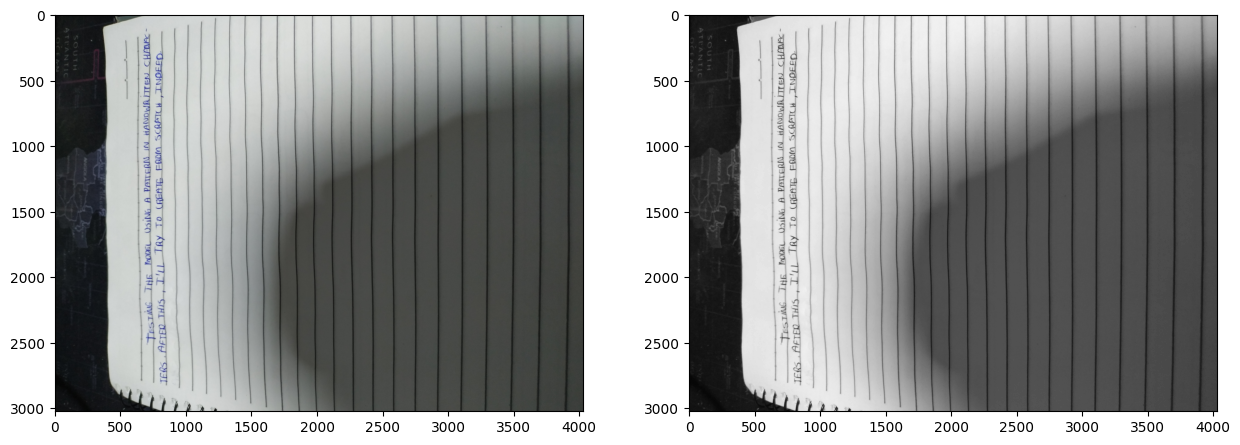

In [30]:
# Setting the plot size to 15,15
tic = time.time()

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)

# Displaying the dataset image
plt.imshow(lst_npimg[-1])

# Converting RGB image to Monochrome
gray_img = rgb2gray(lst_npimg[-1])
plt.subplot(1, 2, 2)

# Displaying the sample image - Monochrome
# Format
plt.imshow(gray_img, cmap="gray")

toc = time.time()
print('Time to plot sample: {}'.format(toc-tic))

### 3.3. Image segmentating by thresholding the dataset

**What are these techniques and why are they being used?**

The Niblack and Sauvola thresholding technique have the objective of improving the quality of microscopic images. 
Otsu’s thresholding creates better contrast of the image as possible to focus on the main objects of it. 

**How do they work?**

Niblack and Sauvola: it’s an approach that changes the threshold depending on the local mean and standard deviation for each pixel in a sliding window. 

Otsu’s thresholding: it works by iterating over all possible threshold values and computing a measure of dispersion for the sample points on either side of the threshold, i.e. either in foreground or background. The goal is to determine the smallest foreground and background spreads possible.

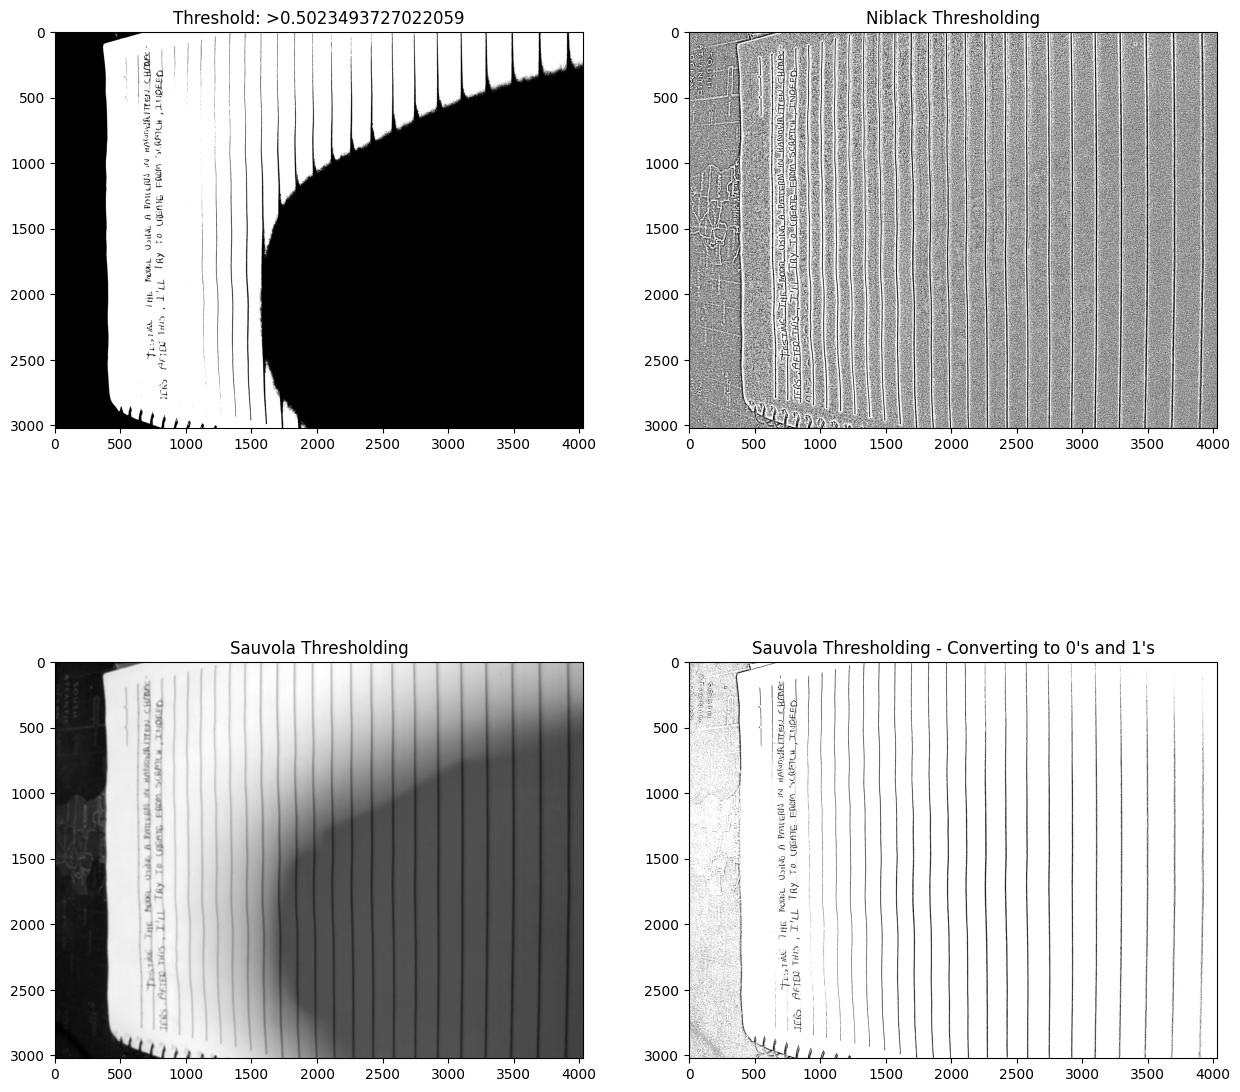

In [36]:
# Setting plot size to 15, 15
plt.figure(figsize=(15, 15))

# Computing Otsu's thresholding value
threshold = filters.threshold_otsu(gray_img)

# Computing binarized values using the obtained
# threshold
binarized_otsu = (gray_img > threshold)*1
plt.subplot(2,2,1)
plt.title("Threshold: >"+str(threshold))

# Displaying the binarized image
plt.imshow(binarized_otsu, cmap = "gray")

# Computing Ni black's local pixel
# threshold values for every pixel
threshold = filters.threshold_niblack(gray_img)

# Computing binarized values using the obtained
# threshold
binarized_niblack = (gray_img > threshold)*1
plt.subplot(2,2,2)
plt.title("Niblack Thresholding")

# Displaying the binarized image
plt.imshow(binarized_niblack, cmap = "gray")

# Computing Sauvola's local pixel threshold
# values for every pixel - Not Binarized
thresh_sauvola = filters.threshold_sauvola(gray_img)
plt.subplot(2,2,3)
plt.title("Sauvola Thresholding")

# Displaying the local threshold values
plt.imshow(thresh_sauvola, cmap = "gray")

# Computing Sauvola's local pixel
# threshold values for every pixel - Binarized
binarized_sauvola = (gray_img > thresh_sauvola)*1
plt.subplot(2,2,4)
plt.title("Sauvola Thresholding - Converting to 0's and 1's")

# Displaying the binarized image
plt.imshow(binarized_sauvola, cmap = "gray")

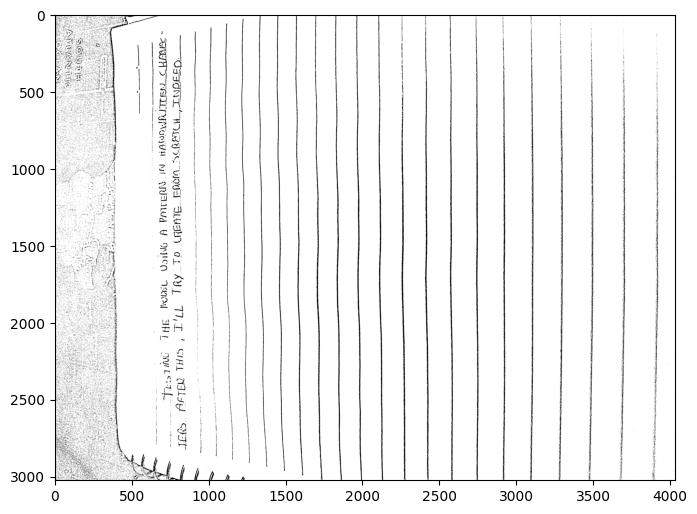

In [37]:
# saving the image to test rotation
sauvola_figura = plt.figure(figsize=(8,8))

# Displaying the binarized image
plt.imshow(binarized_sauvola, cmap = "gray")
plt.savefig('sauvola_figure.jpg')

In [38]:
# Rotating the image so as the text stays horizontally
# rotate 90° a numpy array image
def rotate_image(image_path):
    image = Image.open(image_path)
    image = image.rotate(-90, expand=False)
    image.save(image_path)

rotate_image('sauvola_figure.jpg')

## 4. Modeling

### 4.1. Keras-OCR

In [39]:
import keras_ocr
# This command will execute Keras OCR pre-trained downloading files
pipeline = keras_ocr.pipeline.Pipeline()

Looking for C:\Users\amilt\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\amilt\.keras-ocr\crnn_kurapan.h5


In [42]:
# Each list of predictions in prediction_groups is a list of (word, box) tuples.
prediction_groups = pipeline.recognize(['sauvola_figure.jpg'])

2/2 [==============================] - 6s 372ms/step


In [43]:
# Extract the text from the predictions
text = ''
for prediction in prediction_groups:
    for word in prediction:
        text += word[0] + ' '

print(text)

g g g g s g e g porern i anise crml osilo tne mill d ibims sloe try cenie eocn tnpeeo to till aaen thls sces g g g s g g s 


In [ ]:
fonts = keras_ocr.data_generation.get_fonts(
    alphabet=alphabet,
    cache_dir=data_dir
)